In [1]:
!unzip archive.zip -d /content/

Archive:  archive.zip
  inflating: /content/heart.csv      


In [2]:
!pip install ydata-profiling
!pip install pywaffle
!pip install highlight-text
!pip install Pillow

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 105.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=19f00d3b9aabdd7d36f8e5d1da7b24d7cb5aa84b76770700e38f65c3c2e6115f
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 81.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import ydata_profiling
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import os
import yellowbrick
import joblib

from ydata_profiling import ProfileReport
from pywaffle import Waffle
from statsmodels.graphics.gofplots import qqplot
from PIL import Image
from highlight_text import fig_text
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.contrib.wrapper import wrap
from yellowbrick.style import set_palette

In [4]:
df = pd.read_csv("/content/heart.csv")


df.head().style.hide(axis="index").background_gradient(cmap='Reds')


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
63,1,3,145,233,1,0,150,0,2.300000,0,0,1,1
37,1,2,130,250,0,1,187,0,3.500000,0,0,2,1
41,0,1,130,204,0,0,172,0,1.400000,2,0,2,1
56,1,1,120,236,0,1,178,0,0.800000,2,0,2,1
57,0,0,120,354,0,1,163,1,0.600000,2,0,2,1


# **Data Preprocessing**


In [5]:
color_line = '#FF5733'

ProfileReport(df, title='Heart Disease Dataset Report', minimal=True, progress_bar=False,
              samples=None, correlations=None,
              interactions=None, explorative=True,
              notebook={'iframe':{'height': '600px'}})
color_line = '#FF5733'

ProfileReport(df, title='Heart Disease Dataset Report', minimal=True, progress_bar=False,
              samples=None, correlations=None,
              interactions=None, explorative=True,
              notebook={'iframe':{'height': '600px'}},
              html={'style':{'primary_color': color_line}},
              missing_diagrams={'heatmap': False, 'dendrogram': False})\
.to_notebook_iframe()

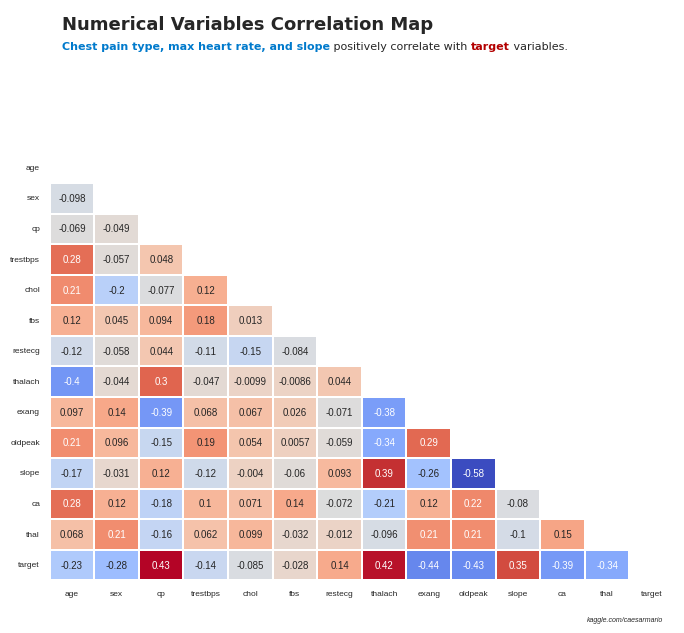

Chia tập dữ liệu (80% training and 20% testing)

In [6]:

x = df.drop(['target'], axis=1)
y = df['target']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("\nSau khi chia train-test:")
print("Shape của x_train:", x_train.shape)  # Khoảng (242, 13)
print("Shape của x_test:", x_test.shape)    # Khoảng (61, 13)
print("Shape của y_train:", y_train.shape)  # Khoảng (242,)
print("Shape của y_test:", y_test.shape)


Sau khi chia train-test:
Shape của x_train: (242, 13)
Shape của x_test: (61, 13)
Shape của y_train: (242,)
Shape của y_test: (61,)


In [7]:
# --- Numerical Pipeline ---
num_column = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
num_pipeline = Pipeline([
    ('scaling', RobustScaler())
])

# --- Categorical Pipeline ---
cat_column = ['cp', 'slope', 'thal']
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# --- Combine Both Pipelines into Transformer ---S
preprocessor = ColumnTransformer([
    ('categorical', cat_pipeline, cat_column)
    , ('numerical', num_pipeline, num_column)]
    , remainder='passthrough')

# --- Apply Transformer to Pipeline ---
process_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# --- Apply to Dataframe ---
x_train_process = process_pipeline.fit_transform(x_train)
x_test_process = process_pipeline.fit_transform(x_test)

In [ ]:
joblib.dump(process_pipeline, 'process_pipeline.pkl')

['process_pipeline.pkl']

# **Logistic Regression**

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
def initialize_weights(n_features):

    return np.zeros(n_features)

In [10]:
def compute_cost(X, y, weights):
    """
    Tính cost function (cross-entropy loss)
    """
    m = len(y)
    h = sigmoid(np.dot(X, weights))
    epsilon = 1e-15  # Để tránh log(0)
    cost = (-1/m) * np.sum(y * np.log(h + epsilon) + (1-y) * np.log(1 - h + epsilon))
    return cost

In [11]:
def gradient_descent(X, y, weights, bias, learning_rate, num_iterations):
    """
    Thực hiện gradient descent để tối ưu hóa weights và bias
    X: ma trận features
    y: vector target
    weights: vector trọng số
    bias: hệ số bias
    """
    m = len(y)  # số lượng mẫu
    cost_history = []

    for i in range(num_iterations):
        # Forward propagation
        z = np.dot(X, weights) + bias
        predictions = sigmoid(z)

        # Tính gradient
        dz = predictions - y
        dw = (1/m) * np.dot(X.T, dz)  # gradient cho weights
        db = (1/m) * np.sum(dz)       # gradient cho bias

        # Cập nhật tham số
        weights = weights - learning_rate * dw
        bias = bias - learning_rate * db

        # Lưu lại cost
        if i % 100 == 0:
            z = np.dot(X, weights) + bias
            predictions = sigmoid(z)
            cost = (-1/m) * np.sum(y * np.log(predictions + 1e-15) +
                                 (1-y) * np.log(1 - predictions + 1e-15))
            cost_history.append(cost)

    return weights, bias, cost_history

In [12]:
def predict(X, weights, bias):
    """
    Dự đoán với weights và bias đã học được
    """
    z = np.dot(X, weights) + bias
    predictions = sigmoid(z)
    return (predictions >= 0.5).astype(int)

In [13]:
# Khởi tạo tham số
learning_rate = 0.01
num_iterations = 1500
n_features = x_train_process.shape[1]

In [14]:
# Khởi tạo weights và bias
initial_weights = np.zeros(n_features)
initial_bias = 0

In [15]:
final_weights, final_bias, cost_history = gradient_descent(
    x_train_process,
    y_train,
    initial_weights,
    initial_bias,
    learning_rate,
    num_iterations
)

In [16]:
import pickle


model_info = {
    'weights': final_weights,
    'bias': final_bias,
    'preprocessor': process_pipeline,
    'num_columns': num_column,
    'cat_columns': cat_column
}

# Lưu model
def save_model(model_info, filename='heart_disease_model.pkl'):
    with open(filename, 'wb') as file:
        pickle.dump(model_info, file)
    print(f"Đã lưu model thành công vào file: {filename}")
save_model(model_info)

Đã lưu model thành công vào file: heart_disease_model.pkl


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7891 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND GRAVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7883 (\N{LATIN SMALL LETTER I WITH DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


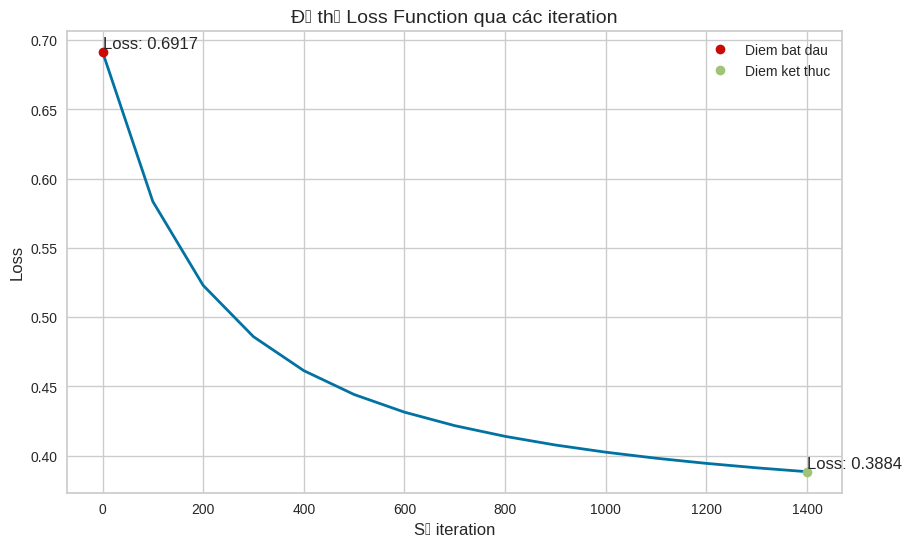

Loss ban đầu: 0.6917
Loss cuối cùng: 0.3884


In [17]:
import matplotlib.pyplot as plt

# Vẽ đồ thị loss
plt.figure(figsize=(10, 6))
plt.plot(range(0, num_iterations, 100), cost_history, 'b-', linewidth=2)
plt.title('Đồ thị Loss Function qua các iteration', fontsize=14)
plt.xlabel('Số iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)

# Thêm điểm bắt đầu và kết thúc
plt.plot(0, cost_history[0], 'ro', label='Diem bat dau')
plt.plot(num_iterations-100, cost_history[-1], 'go', label='Diem ket thuc')

# Thêm giá trị loss
plt.text(0, cost_history[0], f'Loss: {cost_history[0]:.4f}',
         verticalalignment='bottom')
plt.text(num_iterations-100, cost_history[-1], f'Loss: {cost_history[-1]:.4f}',
         verticalalignment='bottom')

plt.legend()
plt.show()

# In ra giá trị loss đầu và cuối
print(f"Loss ban đầu: {cost_history[0]:.4f}")
print(f"Loss cuối cùng: {cost_history[-1]:.4f}")

In [20]:
# Hàm để load model
def load_model(filename='heart_disease_model.pkl'):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

# Hàm để dự đoán với model đã load
def predict_with_loaded_model(X, loaded_model):
    # Lấy weights, bias và preprocessor từ loaded_model
    weights = loaded_model['weights']
    bias = loaded_model['bias']
    preprocessor = loaded_model['preprocessor']

    # Áp dụng preprocessor cho dữ liệu
    X_processed = preprocessor.transform(X)

    # Dự đoán
    predictions = predict(X_processed, weights, bias)
    return predictions

# Load the model
loaded_model = load_model()

Đánh giá mô hình trên tập test:
=== Classification Report ===
Accuracy: 0.9016
Precision: 0.9333
Recall: 0.8750
F1-score: 0.9032
Specificity: 0.9310

Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7921 (\N{LATIN SMALL LETTER U WITH HORN AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7871 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


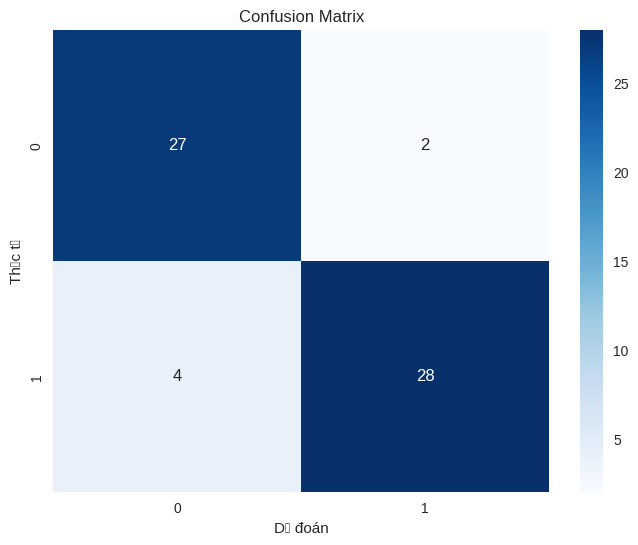


ROC Curve:


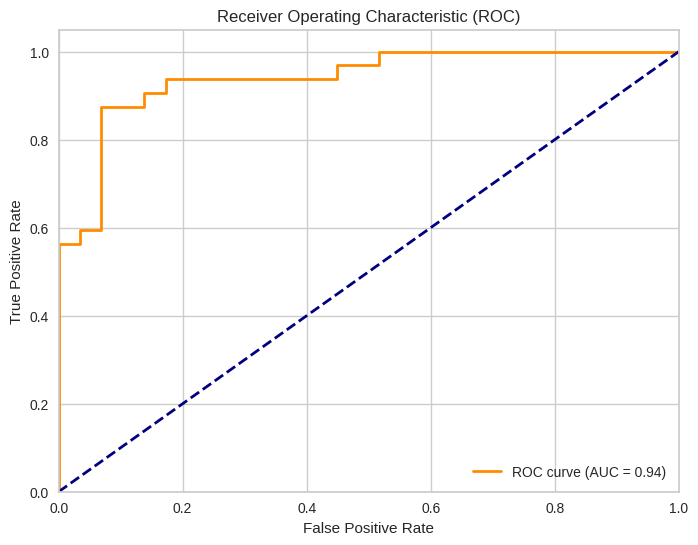

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def calculate_metrics(y_true, y_pred):
    """
    Tính toán các metrics cơ bản
    """
    # Tính confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Tính các metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    specificity = tn / (tn + fp)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'specificity': specificity
    }

def plot_confusion_matrix(y_true, y_pred):
    """
    Vẽ confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Thực tế')
    plt.xlabel('Dự đoán')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba):
    """
    Vẽ đường cong ROC
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def print_classification_report(y_true, y_pred):
    """
    In báo cáo chi tiết về các metrics
    """
    metrics = calculate_metrics(y_true, y_pred)

    print("=== Classification Report ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1_score']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")

def evaluate_model(y_true, y_pred, y_pred_proba=None):
    """
    Đánh giá tổng thể mô hình
    """
    # In metrics
    print_classification_report(y_true, y_pred)

    # Vẽ confusion matrix
    print("\nConfusion Matrix:")
    plot_confusion_matrix(y_true, y_pred)

    # Vẽ ROC curve nếu có xác suất dự đoán
    if y_pred_proba is not None:
        print("\nROC Curve:")
        plot_roc_curve(y_true, y_pred_proba)

# Sử dụng các hàm để đánh giá mô hình:
# Tính xác suất dự đoán
def predict_proba(X, weights, bias):
    z = np.dot(X, weights) + bias
    return 1 / (1 + np.exp(-z))

# Đánh giá trên tập test
X_test_processed = process_pipeline.transform(x_test)
y_pred = predict_with_loaded_model(x_test, loaded_model)
y_pred_proba = predict_proba(X_test_processed, loaded_model['weights'], loaded_model['bias'])

# Đánh giá tổng thể
print("Đánh giá mô hình trên tập test:")
evaluate_model(y_test, y_pred, y_pred_proba)